# Proyecto final Análisis numérico 1

## Librerías

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import torch
import random
import networkx as nx

## Métodos de lectura de datos

In [3]:
# Leer matriz de distancias desde un archivo
def leer_matriz_distancias(filename):
    with open(filename, 'r') as file:
        matriz = []
        for line in file:
            fila = list(map(float, line.strip().split()))
            matriz.append(fila)
    return np.array(matriz)

# Leer coordenadas desde un archivo
def leer_coordenadas(filename):
    with open(filename, 'r') as file:
        coordenadas = []
        for line in file:
            x, y = map(float, line.strip().split())
            coordenadas.append((x, y))
    return coordenadas

## Métodos adicionales

In [4]:
def Graficar(coordenadas, ruta, titulo):
    G = nx.DiGraph()  # Grafo dirigido para la ruta

    # Añadir nodos y sus posiciones
    for i, (x, y) in enumerate(coordenadas):
        G.add_node(i, pos=(x, y))

    # Añadir aristas según la ruta
    for i in range(len(ruta) - 1):
        G.add_edge(ruta[i], ruta[i + 1])

    # Extraer posiciones para la visualización
    pos = nx.get_node_attributes(G, 'pos')

    # Crear la figura
    fig, ax = plt.subplots(figsize=(10, 6))
    nx.draw(G, pos, with_labels=True, node_size=200, node_color='lightblue', font_size=5, font_color='black', font_weight='bold', ax=ax)
    nx.draw_networkx_edges(G, pos, edgelist=G.edges, edge_color='blue', width=2, arrows=True, ax=ax)    
    ax.set_title(f"Ruta del TSP - {titulo}")
    ax.grid(True)
    
    return fig, ax

In [5]:
#Comprobar que la ruta es factible, y que no se repiten ciudades, además de la primera
def comprobar_ruta(ruta, coordenadas):
    nodos = {i: coord for i, coord in enumerate(coordenadas)}
    c1 = set(ruta) == set(nodos.keys())
    c2 = len(ruta) == len(nodos) + 1
    if c1 and c2:
        print("La ruta es factible.")
    else:
        print("La ruta no es factible.")

In [5]:
# Función 2-opt para mejorar una ruta
def dos_opt(ruta, matriz_distancias):
    n = len(ruta)
    mejora = True
    while mejora:
        mejora = False
        for i in range(1, n - 2):
            for j in range(i + 1, n - 1):
                if j - i == 1:
                    continue
                costo_actual = (
                    matriz_distancias[ruta[i - 1], ruta[i]]
                    + matriz_distancias[ruta[j], ruta[j + 1]]
                )
                nuevo_costo = (
                    matriz_distancias[ruta[i - 1], ruta[j]]
                    + matriz_distancias[ruta[i], ruta[j + 1]]
                )
                if nuevo_costo < costo_actual:
                    ruta[i:j + 1] = reversed(ruta[i:j + 1])
                    mejora = True
    return ruta

In [6]:
archivo_matriz = 'Distancia.txt'
archivo_coordenadas = 'Coordenadas.txt'

# Leer archivos
matriz_distancias = leer_matriz_distancias(archivo_matriz)
coordenadas = leer_coordenadas(archivo_coordenadas)

In [12]:
matriz_distancias.tolist()

[[0.0,
  58.3867,
  12.4185,
  73.8024,
  49.1522,
  69.8627,
  17.6958,
  93.1051,
  54.2284,
  71.4491,
  22.6086,
  74.5701,
  25.0765,
  5.3885,
  8.4619,
  65.0875,
  34.7777,
  79.1291,
  23.0962,
  15.9389,
  28.1924,
  79.6115,
  80.2786,
  8.2925,
  81.1678,
  77.594,
  73.3135,
  65.4446,
  55.3725,
  50.4941,
  57.7946,
  82.6274,
  47.1772,
  41.3028,
  39.1589,
  76.6668,
  78.5521,
  75.2871,
  80.6847,
  53.8375,
  59.2773,
  67.8522,
  11.9148,
  69.1992,
  56.4496,
  75.942,
  68.6274,
  78.9885,
  61.6115,
  59.8622,
  45.2191,
  43.2574,
  6.2294,
  59.6037,
  65.4906,
  75.3604,
  94.6716,
  37.15,
  95.8088,
  43.7009,
  33.8782,
  69.1572,
  23.2216,
  54.7819,
  46.4587,
  86.8906,
  26.4716,
  34.452,
  83.1403,
  15.8898,
  118.3268,
  83.6267,
  27.3999,
  68.2846,
  87.043,
  48.2191,
  72.1033,
  30.0051,
  79.8699,
  84.3649,
  73.7965,
  89.7464,
  69.5758,
  81.742,
  90.0801,
  7.3115,
  53.9537,
  32.3639,
  61.3068,
  62.5583,
  9.3981,
  69.6427,
  32

In [16]:
"""Simple Travelling Salesperson Problem (TSP) between cities."""

from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp


def create_data_model(dist):
    """Stores the data for the problem."""
    data = {}
    ss = [
        [0, 2451, 713, 1018, 1631, 1374, 2408, 213, 2571, 875, 1420, 2145, 1972],
        [2451, 0, 1745, 1524, 831, 1240, 959, 2596, 403, 1589, 1374, 357, 579],
        [713, 1745, 0, 355, 920, 803, 1737, 851, 1858, 262, 940, 1453, 1260],
        [1018, 1524, 355, 0, 700, 862, 1395, 1123, 1584, 466, 1056, 1280, 987],
        [1631, 831, 920, 700, 0, 663, 1021, 1769, 949, 796, 879, 586, 371],
        [1374, 1240, 803, 862, 663, 0, 1681, 1551, 1765, 547, 225, 887, 999],
        [2408, 959, 1737, 1395, 1021, 1681, 0, 2493, 678, 1724, 1891, 1114, 701],
        [213, 2596, 851, 1123, 1769, 1551, 2493, 0, 2699, 1038, 1605, 2300, 2099],
        [2571, 403, 1858, 1584, 949, 1765, 678, 2699, 0, 1744, 1645, 653, 600],
        [875, 1589, 262, 466, 796, 547, 1724, 1038, 1744, 0, 679, 1272, 1162],
        [1420, 1374, 940, 1056, 879, 225, 1891, 1605, 1645, 679, 0, 1017, 1200],
        [2145, 357, 1453, 1280, 586, 887, 1114, 2300, 653, 1272, 1017, 0, 504],
        [1972, 579, 1260, 987, 371, 999, 701, 2099, 600, 1162, 1200, 504, 0],
    ]
    data["distance_matrix"] = dist
    data["num_vehicles"] = 1
    data["depot"] = 0
    return data


def print_solution(manager, routing, solution):
    """Prints solution on console."""
    print(f"Objective: {solution.ObjectiveValue()} miles")
    index = routing.Start(0)
    plan_output = "Route for vehicle 0:\n"
    route_distance = 0
    while not routing.IsEnd(index):
        plan_output += f" {manager.IndexToNode(index)} ->"
        previous_index = index
        index = solution.Value(routing.NextVar(index))
        route_distance += routing.GetArcCostForVehicle(previous_index, index, 0)
    plan_output += f" {manager.IndexToNode(index)}\n"
    print(plan_output)
    plan_output += f"Route distance: {route_distance}miles\n"


def main():
    """Entry point of the program."""
    # Instantiate the data problem.
    data = create_data_model(matriz_distancias.tolist())

    # Create the routing index manager.
    manager = pywrapcp.RoutingIndexManager(
        len(data["distance_matrix"]), data["num_vehicles"], data["depot"]
    )

    # Create Routing Model.
    routing = pywrapcp.RoutingModel(manager)


    def distance_callback(from_index, to_index):
        """Returns the distance between the two nodes."""
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data["distance_matrix"][from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)

    # Define cost of each arc.
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Setting first solution heuristic.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
    )

    # Solve the problem.
    solution = routing.SolveWithParameters(search_parameters)

    # Print solution on console.
    if solution:
        print_solution(manager, routing, solution)


if __name__ == "__main__":
    main()

Objective: 0 miles
Route for vehicle 0:
 0 -> 299 -> 298 -> 297 -> 296 -> 295 -> 294 -> 293 -> 292 -> 291 -> 290 -> 289 -> 288 -> 287 -> 286 -> 285 -> 284 -> 283 -> 282 -> 281 -> 280 -> 279 -> 278 -> 277 -> 276 -> 275 -> 274 -> 273 -> 272 -> 271 -> 270 -> 269 -> 268 -> 267 -> 266 -> 265 -> 264 -> 263 -> 262 -> 261 -> 260 -> 259 -> 258 -> 257 -> 256 -> 255 -> 254 -> 253 -> 252 -> 251 -> 250 -> 249 -> 248 -> 247 -> 246 -> 245 -> 244 -> 243 -> 242 -> 241 -> 240 -> 239 -> 238 -> 237 -> 236 -> 235 -> 234 -> 233 -> 232 -> 231 -> 230 -> 229 -> 228 -> 227 -> 226 -> 225 -> 224 -> 223 -> 222 -> 221 -> 220 -> 219 -> 218 -> 217 -> 216 -> 215 -> 214 -> 213 -> 212 -> 211 -> 210 -> 209 -> 208 -> 207 -> 206 -> 205 -> 204 -> 203 -> 202 -> 201 -> 200 -> 199 -> 198 -> 197 -> 196 -> 195 -> 194 -> 193 -> 192 -> 191 -> 190 -> 189 -> 188 -> 187 -> 186 -> 185 -> 184 -> 183 -> 182 -> 181 -> 180 -> 179 -> 178 -> 177 -> 176 -> 175 -> 174 -> 173 -> 172 -> 171 -> 170 -> 169 -> 168 -> 167 -> 166 -> 165 -> 164 -> 16

58.3867

## Métodos de resolver el problema

### Ant colony optimization con 2-opt

In [6]:
# Algoritmo de colonia de hormigas (ACO) con PyTorch y CUDA
class ACO:
    def __init__(self, matriz_distancias, num_hormigas, num_iteraciones, alpha=1.0, beta=5.0, rho=0.5, q=100, elitismo=0.1, evaporacion_global=0.1):
        # Mover la matriz de distancias y las feromonas a la GPU si CUDA está disponible
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        # Convertir matrices a tensores en la GPU
        self.matriz_distancias = torch.tensor(matriz_distancias, dtype=torch.float32).to(self.device)
        self.num_ciudades = self.matriz_distancias.shape[0]
        self.num_hormigas = num_hormigas
        self.num_iteraciones = num_iteraciones
        self.alpha = alpha
        self.beta = beta
        self.rho = rho
        self.q = q
        self.elitismo = elitismo
        self.evaporacion_global = evaporacion_global
        
        # Inicializar las feromonas en la GPU
        self.feromonas = torch.ones((self.num_ciudades, self.num_ciudades), dtype=torch.float32).to(self.device) / self.num_ciudades

    def _calcular_probabilidades(self, ciudad_actual, no_visitadas):
        # Asegurarse de que las operaciones se realicen en la GPU
        feromonas = self.feromonas[ciudad_actual][no_visitadas]
        visibilidad = 1 / self.matriz_distancias[ciudad_actual][no_visitadas]
        probabilidades = (feromonas ** self.alpha) * (visibilidad ** self.beta)
        return probabilidades / probabilidades.sum()

    def _actualizar_feromonas(self, rutas, costes, mejor_ruta_global):
        # Asegurarse de que las operaciones se realicen en la GPU
        self.feromonas *= (1 - self.evaporacion_global)
        mejor_coste_global = float('inf')
        for ruta, coste in zip(rutas, costes):
            if coste < mejor_coste_global:
                mejor_coste_global = coste
                mejor_ruta_global = ruta
        for i in range(len(mejor_ruta_global) - 1):
            ciudad_actual = mejor_ruta_global[i]
            siguiente_ciudad = mejor_ruta_global[i + 1]
            self.feromonas[ciudad_actual, siguiente_ciudad] += self.q / mejor_coste_global
            self.feromonas[siguiente_ciudad, ciudad_actual] += self.q / mejor_coste_global
        for ruta, coste in zip(rutas, costes):
            for i in range(len(ruta) - 1):
                ciudad_actual = ruta[i]
                siguiente_ciudad = ruta[i + 1]
                self.feromonas[ciudad_actual, siguiente_ciudad] += self.q / coste
                self.feromonas[siguiente_ciudad, ciudad_actual] += self.q / coste

    def resolver(self, tiempo_limite):
        mejor_ruta_global = None
        mejor_coste_global = float('inf')
        inicio_tiempo = time.time()
        
        for _ in range(self.num_iteraciones):
            if time.time() - inicio_tiempo > tiempo_limite:
                break
            
            rutas = []
            costes = []
            
            # Paralelizar la simulación de las hormigas usando PyTorch y CUDA
            for _ in range(self.num_hormigas):
                ruta = [np.random.randint(self.num_ciudades)]
                for _ in range(self.num_ciudades - 1):
                    ciudad_actual = ruta[-1]
                    no_visitadas = list(set(range(self.num_ciudades)) - set(ruta))
                    probabilidades = self._calcular_probabilidades(ciudad_actual, no_visitadas)
                    siguiente_ciudad = np.random.choice(no_visitadas, p=probabilidades.cpu().numpy())
                    ruta.append(siguiente_ciudad)
                ruta.append(ruta[0])  # Volver al inicio
                ruta = dos_opt(ruta, self.matriz_distancias.cpu().numpy())  # Aplicar 2-opt
                rutas.append(ruta)
                coste = sum(self.matriz_distancias[ruta[i], ruta[i + 1]].item() for i in range(len(ruta) - 1))
                costes.append(coste)
            
            self._actualizar_feromonas(rutas, costes, mejor_ruta_global)
            for ruta, coste in zip(rutas, costes):
                if coste < mejor_coste_global:
                    mejor_coste_global = coste
                    mejor_ruta_global = ruta

        return mejor_ruta_global, mejor_coste_global

In [7]:
# Archivos de entrada
archivo_matriz = 'Distancia.txt'
archivo_coordenadas = 'Coordenadas.txt'

# Leer archivos
matriz_distancias = leer_matriz_distancias(archivo_matriz)
coordenadas = leer_coordenadas(archivo_coordenadas)

# Configurar y ejecutar ACO
num_hormigas = 25
num_iteraciones = 100
tiempo_limite = 110  # Límite de tiempo en segundos

inicio = time.time()
aco = ACO(matriz_distancias, num_hormigas, num_iteraciones)
ruta, coste = aco.resolver(tiempo_limite)
fin = time.time()

# Mostrar resultado
print(f'\nCosto de la mejor ruta: {coste}')
print(f'Ruta: {ruta}')
print(f'\nTiempo de ejecución: {fin - inicio:.2f} segundos')


Costo de la mejor ruta: 1368.1352984309196
Ruta: [262, 228, 174, 128, 230, 131, 178, 106, 17, 274, 112, 218, 22, 78, 79, 291, 21, 158, 110, 45, 80, 76, 194, 268, 54, 269, 148, 86, 258, 263, 117, 189, 235, 266, 192, 215, 87, 165, 190, 10, 18, 6, 286, 69, 255, 267, 52, 231, 276, 85, 251, 227, 0, 13, 14, 187, 185, 90, 149, 134, 23, 126, 42, 159, 108, 186, 20, 232, 282, 169, 12, 66, 72, 77, 92, 16, 247, 249, 188, 233, 119, 299, 50, 32, 168, 127, 199, 39, 153, 240, 239, 15, 285, 5, 203, 27, 136, 25, 150, 214, 238, 11, 73, 183, 265, 201, 93, 220, 132, 139, 38, 113, 256, 98, 294, 101, 164, 213, 283, 103, 71, 65, 141, 243, 144, 287, 120, 26, 124, 197, 37, 145, 223, 74, 102, 161, 180, 31, 298, 81, 129, 175, 7, 275, 111, 56, 221, 125, 177, 58, 253, 95, 296, 70, 146, 123, 171, 114, 281, 130, 229, 217, 9, 61, 122, 94, 222, 49, 109, 181, 53, 88, 219, 104, 43, 105, 3, 47, 36, 212, 279, 166, 84, 191, 195, 68, 205, 160, 225, 259, 176, 142, 211, 272, 157, 208, 83, 24, 278, 35, 293, 55, 179, 277, 46, 4

In [ ]:
comprobar_ruta(ruta, coordenadas)

La ruta es factible.


: 

In [ ]:
fig, ax = Graficar(coordenadas, ruta, 'ACO')


Costo de la mejor ruta: 1353.5815002322197
Ruta: [3, 217, 229, 281, 130, 102, 74, 223, 37, 145, 9, 61, 122, 94, 222, 49, 181, 109, 88, 53, 137, 289, 63, 200, 244, 4, 152, 210, 234, 270, 206, 115, 99, 62, 173, 140, 257, 250, 267, 19, 163, 236, 292, 97, 133, 284, 67, 60, 100, 198, 34, 51, 207, 138, 264, 290, 184, 297, 28, 167, 116, 41, 104, 219, 105, 43, 205, 160, 142, 211, 272, 157, 176, 259, 225, 46, 277, 179, 55, 293, 278, 35, 208, 83, 24, 17, 274, 112, 79, 218, 22, 78, 291, 158, 21, 110, 45, 80, 76, 194, 268, 54, 269, 148, 86, 258, 263, 117, 174, 128, 230, 131, 178, 106, 204, 151, 147, 30, 182, 155, 121, 262, 228, 29, 75, 59, 189, 235, 266, 192, 215, 87, 165, 190, 18, 10, 286, 6, 69, 255, 276, 231, 52, 0, 227, 251, 85, 13, 14, 185, 187, 90, 149, 134, 23, 126, 42, 118, 2, 280, 271, 202, 261, 288, 242, 57, 254, 154, 44, 193, 64, 249, 188, 233, 119, 247, 20, 186, 108, 159, 232, 282, 169, 12, 66, 72, 77, 16, 92, 299, 50, 32, 168, 127, 199, 39, 240, 153, 239, 15, 285, 5, 203, 27, 136, 25

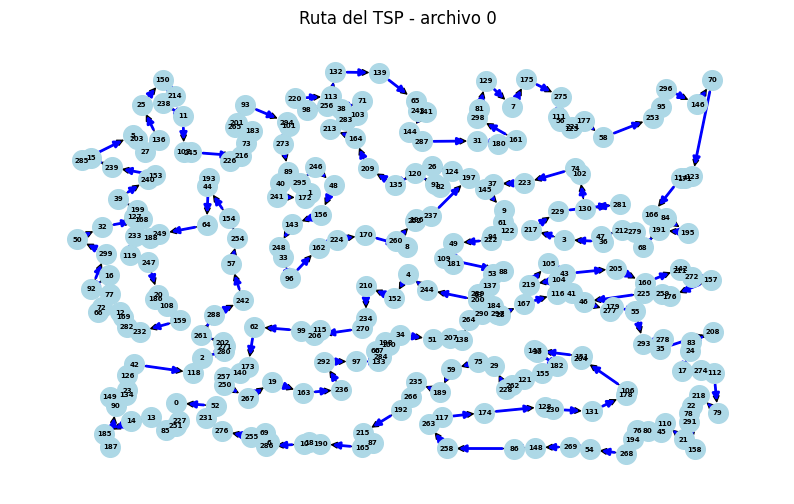

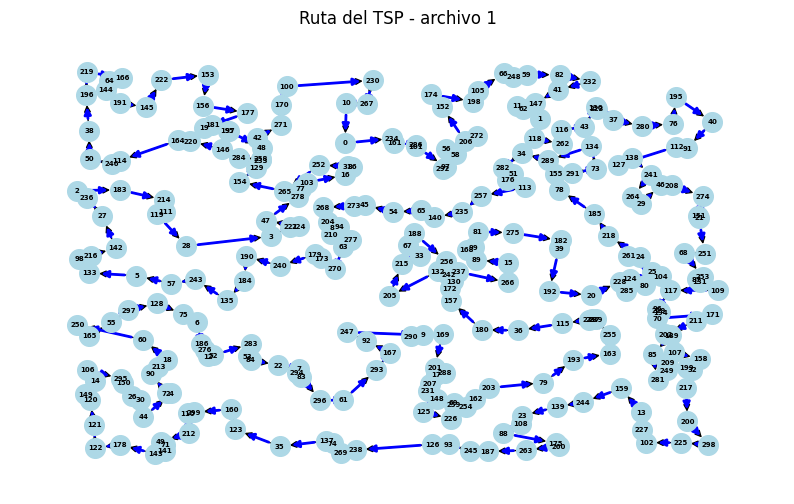

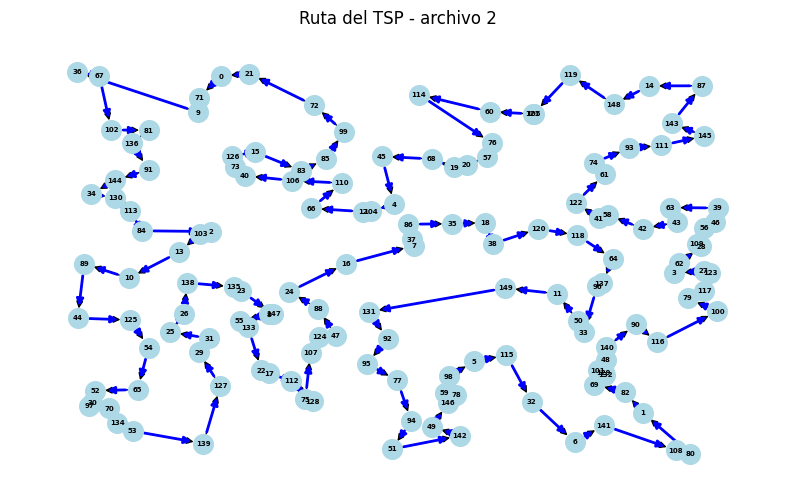

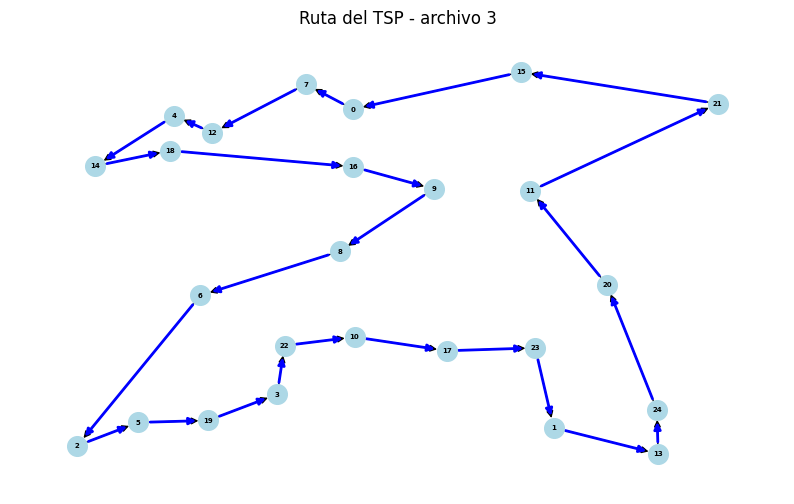

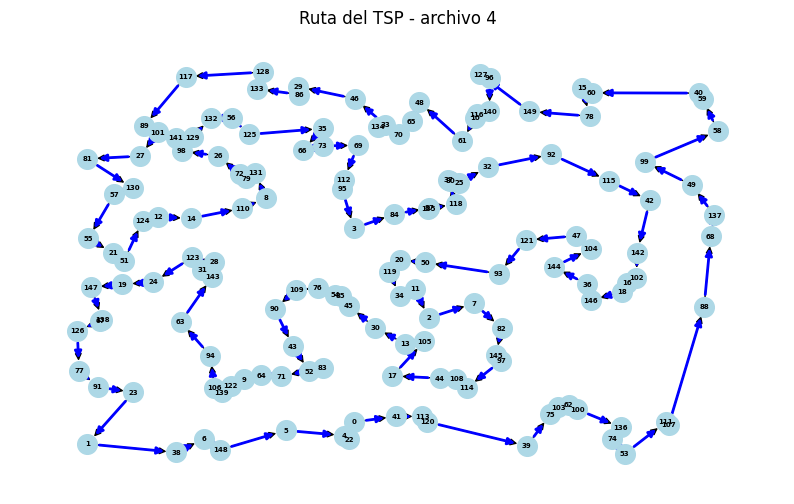

In [ ]:
## Probar para todos los archivos

# Archivos de entrada

distancias_archivos = ['Distancia.txt', 'Dist1.txt', 'Dist2.txt', 'Dist3.txt', 'Dist4.txt']
coordenadas_archivos = ['Coordenadas.txt', 'Coord1.txt', 'Coord2.txt', 'Coord3.txt', 'Coord4.txt']
factible = []
graficas = []
tiempos = []

for i in range(len(distancias_archivos)):
    # Leer archivos
    matriz_distancias = leer_matriz_distancias(distancias_archivos[i])
    coordenadas = leer_coordenadas(coordenadas_archivos[i])

    # Configurar y ejecutar ACO
    num_hormigas = 25
    num_iteraciones = 100
    tiempo_limite = 110  # Límite de tiempo en segundos

    inicio = time.time()
    aco = ACO(matriz_distancias, num_hormigas, num_iteraciones)
    ruta, coste = aco.resolver(tiempo_limite)
    fin = time.time()

    # Mostrar resultado
    print(f'\nCosto de la mejor ruta: {coste}')
    print(f'Ruta: {ruta}')
    print(f'\nTiempo de ejecución: {fin - inicio:.2f} segundos')
    
    tiempos.append(fin - inicio)
    factible.append(comprobar_ruta(ruta, coordenadas))
    fig, ax = Graficar(coordenadas, ruta, "archivo " + str(i))
    graficas.append(fig)

### Nearest neighbor con Tabú search

In [ ]:
# Función para calcular el costo de una ruta utilizando GPU (PyTorch)
def calcular_costo_ruta_gpu(ruta, matriz_distancias_gpu):
    ruta_tensor = torch.tensor(ruta, device='cuda', dtype=torch.long)
    costo = matriz_distancias_gpu[ruta_tensor[:-1], ruta_tensor[1:]].sum()  # Suma directa de distancias
    return costo.item()

# Función para obtener la solución inicial con el algoritmo Nearest Neighbor
def nearest_neighbor(matriz_distancias):
    n = len(matriz_distancias)
    ruta = [0]  # Comienza desde la ciudad 0
    visitados = [False] * n
    visitados[0] = True
    for _ in range(n - 1):
        ultimo_ciudad = ruta[-1]
        siguiente_ciudad = min(
            [(i, matriz_distancias[ultimo_ciudad][i]) for i in range(n) if not visitados[i]], key=lambda x: x[1]
        )[0]
        ruta.append(siguiente_ciudad)
        visitados[siguiente_ciudad] = True
    ruta.append(ruta[0])  # Regresar a la ciudad inicial
    return ruta

# Función de intercambio 2-opt
def generar_vecinos_2opt(ruta):
    vecinos = []
    n = len(ruta)
    for i in range(1, n - 2):
        for j in range(i + 1, n - 1):
            nuevo_vecino = ruta[:i] + ruta[i:j][::-1] + ruta[j:]
            vecinos.append(nuevo_vecino)
    return vecinos

# Evaluación de costos para los vecinos de forma paralela usando GPU
def evaluar_vecinos_gpu(vecinos, matriz_distancias_gpu):
    rutas_tensor = [torch.tensor(vecino, device='cuda', dtype=torch.long) for vecino in vecinos]
    costos = []
    for ruta_tensor in rutas_tensor:
        costo = matriz_distancias_gpu[ruta_tensor[:-1], ruta_tensor[1:]].sum()
        costos.append((ruta_tensor.cpu().numpy().tolist(), costo.item()))
    return costos

# Implementación de Tabu Search con PyTorch (GPU)
def tabu_search(matriz_distancias, tiempo_maximo=60, tamaño_tabu=10):
    # Mover la matriz de distancias a la GPU
    matriz_distancias_gpu = torch.tensor(matriz_distancias, device='cuda', dtype=torch.float32)
    
    inicio = time.time()
    num_ciudades = len(matriz_distancias)
    
    # Generar una solución inicial utilizando Nearest Neighbor
    mejor_ruta = nearest_neighbor(matriz_distancias)
    mejor_costo = calcular_costo_ruta_gpu(mejor_ruta, matriz_distancias_gpu)
    
    # Configuración inicial
    ruta_actual = mejor_ruta[:]
    costo_actual = mejor_costo
    lista_tabu = []
    historial_costos = [mejor_costo]
    
    while time.time() - inicio < tiempo_maximo:
        # Generar vecinos utilizando 2-opt
        vecinos = generar_vecinos_2opt(ruta_actual)
        
        # Evaluar los costos de los vecinos de manera paralela en GPU
        vecinos_costos = evaluar_vecinos_gpu(vecinos, matriz_distancias_gpu)
        
        # Ordenar vecinos por costo ascendente
        vecinos_costos.sort(key=lambda x: x[1])
        
        # Seleccionar el mejor vecino no tabú o una solución aspiracional
        seleccionado = None
        for vecino, costo in vecinos_costos:
            if vecino not in lista_tabu or costo < mejor_costo:
                seleccionado = (vecino, costo)
                break
        
        # Actualizar la solución actual y el mejor encontrado
        if seleccionado:
            ruta_actual, costo_actual = seleccionado
            if costo_actual < mejor_costo:
                mejor_ruta = ruta_actual[:]
                mejor_costo = costo_actual
            
            # Actualizar la lista Tabú
            lista_tabu.append(ruta_actual)
            if len(lista_tabu) > tamaño_tabu:
                lista_tabu.pop(0)
        
        # Registrar el costo actual para graficar la convergencia
        historial_costos.append(mejor_costo)
    
    # Graficar la convergencia
    plt.plot(historial_costos)
    plt.xlabel('Iteración')
    plt.ylabel('Mejor Costo')
    plt.title('Convergencia de Tabu Search')
    plt.show()
    
    return mejor_ruta, mejor_costo, time.time() - inicio

CUDA disponible


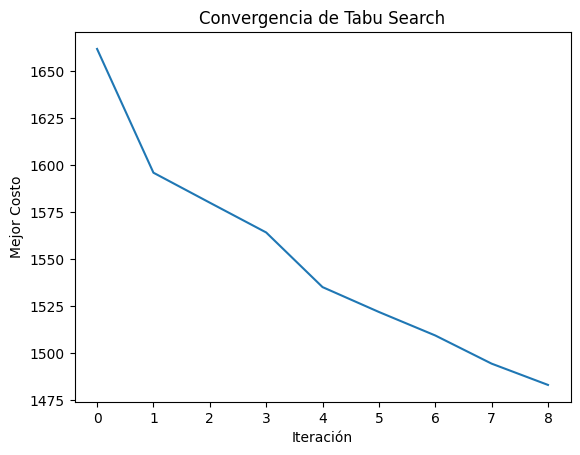

Mejor ruta encontrada: [0, 227, 251, 85, 13, 14, 90, 149, 134, 23, 126, 42, 232, 282, 169, 12, 72, 66, 77, 92, 16, 299, 119, 247, 188, 249, 233, 168, 127, 199, 39, 240, 153, 27, 203, 5, 136, 107, 245, 226, 216, 73, 183, 265, 201, 93, 220, 98, 256, 38, 103, 283, 213, 164, 273, 101, 294, 113, 71, 139, 132, 65, 243, 141, 144, 287, 31, 180, 161, 298, 81, 7, 175, 129, 275, 111, 56, 221, 125, 177, 58, 253, 95, 296, 146, 70, 123, 171, 114, 102, 74, 217, 229, 130, 281, 166, 84, 191, 279, 212, 36, 47, 3, 105, 43, 104, 219, 167, 116, 41, 46, 277, 179, 55, 195, 68, 205, 160, 225, 259, 176, 272, 211, 142, 157, 208, 83, 24, 35, 278, 293, 17, 274, 112, 158, 21, 79, 218, 22, 78, 291, 110, 45, 80, 76, 194, 268, 54, 269, 148, 86, 258, 263, 117, 174, 128, 230, 131, 178, 106, 147, 30, 151, 204, 182, 155, 121, 228, 262, 29, 75, 59, 189, 235, 266, 192, 236, 163, 19, 173, 140, 250, 257, 118, 2, 280, 271, 202, 62, 99, 115, 206, 292, 97, 133, 284, 60, 67, 100, 198, 34, 51, 207, 138, 264, 290, 28, 297, 184, 20

In [ ]:
archivo_matriz = 'Distancia.txt'
archivo_coordenadas = 'Coordenadas.txt'

matriz_distancias = leer_matriz_distancias(archivo_matriz)
coordenadas = leer_coordenadas(archivo_coordenadas)

# Parámetros de Tabu Search
tiempo_maximo = 110  # Tiempo límite en segundos
tamaño_tabu = 20     # Tamaño de la lista Tabú

if torch.cuda.is_available():
    print("CUDA disponible")

# Ejecutar Tabu Search
mejor_ruta, mejor_costo, tiempo_total = tabu_search(matriz_distancias, tiempo_maximo, tamaño_tabu)

# Resultados
print("Mejor ruta encontrada:", mejor_ruta)
print("Costo de la mejor ruta:", mejor_costo)
print("Tiempo total de ejecución:", tiempo_total, "segundos")
print("Semilla:", random.getstate()[1][0])

In [ ]:
comprobar_ruta(ruta, coordenadas)

La ruta es factible.


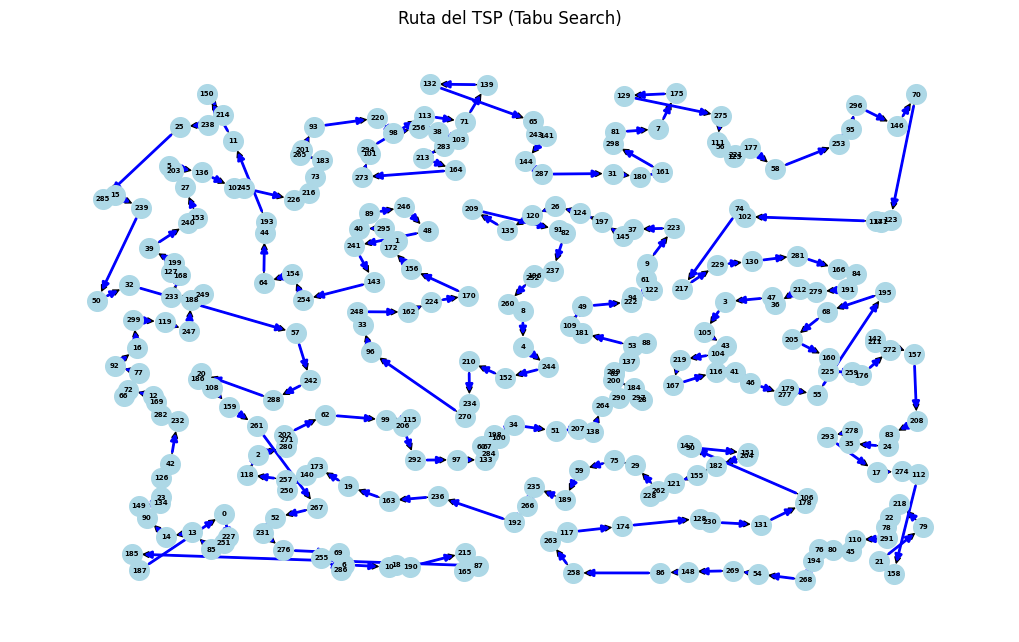

In [ ]:
Graficar(coordenadas, mejor_ruta)